# **Fibonacci Sequence**

[<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Fibonacci_Spiral.svg" width=300 height=300>](https://commons.wikimedia.org/wiki/File:Fibonacci_Spiral.svg)

The *Fibonacci sequence* is the sequence of numbers defined as follows:

$F_0 = 0$

$F_1 = 1$

$\vdots$

$F_n = F_{n-1} + F_{n-2}$

The goal in this example is to train a neural network that learn to predict the Fibonacci sequence using the sequence of numbers as training data.

### *Generate the Fibonacci Sequence in Python*

In [3]:
import torch

import torch
torch.manual_seed(0)

# Generate the fibonacci numbers
M = 20
F = torch.zeros(M+1, 1)  # initialize a column vector

F[0] = 0; F[1] = 1
for n in range(2, M+1):
  F[n] = F[n-1] + F[n-2]

### *Generate Subsequences*

Generate the subsequences of the Fibonacci sequence to use as training data.

In [5]:
# Hyperparameter
TIME_STEPS = 4

# Generate sequences of length TIME_STEPS
m = M - TIME_STEPS + 1

G = torch.zeros(m, TIME_STEPS, 1)
for i in range(m):
  G[i] = F[i:i+TIME_STEPS]

print(f"The sequence of Fibonacci numbers :\n\n{F.T[0].long().tolist()}", f"\n\nand the {len(G)} subsequences of size {TIME_STEPS}:\n\n{G.long()}")

The sequence of Fibonacci numbers :

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765] 

and the 17 subsequences of size 4:

tensor([[[   0],
         [   1],
         [   1],
         [   2]],

        [[   1],
         [   1],
         [   2],
         [   3]],

        [[   1],
         [   2],
         [   3],
         [   5]],

        [[   2],
         [   3],
         [   5],
         [   8]],

        [[   3],
         [   5],
         [   8],
         [  13]],

        [[   5],
         [   8],
         [  13],
         [  21]],

        [[   8],
         [  13],
         [  21],
         [  34]],

        [[  13],
         [  21],
         [  34],
         [  55]],

        [[  21],
         [  34],
         [  55],
         [  89]],

        [[  34],
         [  55],
         [  89],
         [ 144]],

        [[  55],
         [  89],
         [ 144],
         [ 233]],

        [[  89],
         [ 144],
         [ 233],
         [ 37

### *Split Data Into Training and Test Components*

Preprocess the data by normalizing the Fibonacci numbers by the largest value. Then split the data into the training and test components.

In [7]:
# Normalize the values by the maximum
normalizer = 10 / F[-1].item()  # seq is increasing => max = last value

# Split the fibonacci numbers into training and test components
N = int(.8 * m)  # Size of the training set = 80% of original data set
permute = torch.randperm(m)

x_train = G[permute][0:N] * normalizer
y_train = F[permute+TIME_STEPS][0:N] * normalizer

x_test = G[permute][N:] * normalizer
y_test = F[permute+TIME_STEPS][N:] * normalizer

# Save the indices of the test set for later use
test_set = permute[N:].long().tolist()

#print(N, G.shape, F.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#print(train_idxs, test_idxs)

### *Recurrent Neural Network*

RNN with 1 input neuron, 1 recurrent layer and 1 linear layer with a single output neuron.

In [9]:
from torch import nn

class FibNet_RNN(nn.Module):

  def __init__(self, hidden_size, input_size=1, output_size=1, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                      batch_first=True,
                      nonlinearity='relu')
    self.linear = nn.Linear(hidden_size, output_size) #perceptron

    self.is_rnn = True

  def forward(self, x): # x represents the input; a sequence of values
    # Initialize the hidden state with all zeros
    batch_size = len(x)
    H_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size) # initial hidden state for the first time step

    # Pass a sequence of values thru the recurrent layer(s)
    out, _ = self.rnn(x, H_0) 

    # Pass the final output (as sequence of values; 4 in this ex.) at the final layer to the fully-connected layer
    y = self.linear(out[:, -1, :]) #get only the last output value (the prediction of the previous fib. sequence)

    return y

### *Train the Network*


In [11]:
# Import deepcopy to save model state from epoch to epoch
#from copy import deepcopy

# Hyperparameters
HIDDEN_NEURONS = 4 # RNN

LEARNING_RATE = .0001
MOMENTUM = .9
EPOCHS = 3000
EPOCH_SAVE_FREQ = 200 # Frequency with which to save data

# Create an instance of the neural net
model = FibNet_RNN(hidden_size=HIDDEN_NEURONS)

# Choose a loss function and an optimizer
loss_fn = nn.MSELoss()  # Mean-square error loss for numerical data
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)  # Stochastic gradient descent

# Divide the data into batches
batch_size = 1
num_batches = N//batch_size  # Integer division

# Store model data and loss for later analysis
train_loss_data = []
test_loss_data = []

model_versions = {}

# Train the net for multiple epochs
for epoch in range(EPOCHS):
  # Shuffle the data to create a random sample
  permute = torch.randperm(N)  # shuffle the numbers 0, 1, ..., N - 1
  x_shuffled = x_train[permute]  # use the permutation to index X in a random order
  y_shuffled = y_train[permute]  # same for y

  # Training loop:  Calculate SGD using batches of batch_size
  train_loss = 0
  for i in range(num_batches):
    # Grab data in batches
    x_batch = x_shuffled[i:(i+batch_size)]
    y_batch = y_shuffled[i:(i+batch_size)]

    # Zero out the gradient for next iteration
    optimizer.zero_grad()

    # Compute prediction and loss for the current batch
    y_pred = model(x_batch)  # forward propagation
    loss = loss_fn(y_pred, y_batch)  # Computes 1/batch_size * abs(y_pred - y).sum()
    train_loss += loss.item()

    # Backpropagation -- adjust the weights to reduce the loss
    loss.backward()  # numerically compute gradient = d(loss_fn)/dw for each w
    optimizer.step()  # update weights to move in the direction of the gradient

  # Calculate some summary statistics for the current epoch
  avg_train_loss = train_loss/num_batches

  # Test loop
  with torch.no_grad():
    test_loss = 0
    for i, x in enumerate(x_test):
      # Use the next Fibonacci number
      x = x[None, :] #if model.is_rnn else x
      y_pred = model(x)

      # Calculate the loss
      y_true = y_test[None, i]
      loss = loss_fn(y_pred, y_true)
      test_loss += loss.item()

    avg_test_loss = test_loss / len(x_test)

  # Save some data every few epochs; always save the first epoch
  if ((epoch+1) % EPOCH_SAVE_FREQ == 0 or epoch == 0):
    train_loss_data.append(avg_train_loss)
    test_loss_data.append(avg_test_loss)

    filename = f"model_weights{epoch+1:02d}.pth"
    torch.save(model.state_dict(), filename)

    print(f"Epoch {epoch+1:5d}:  Training Loss = {avg_train_loss:.5f}; Test Loss = {avg_test_loss:.5f}")

print("\nDone!")

Epoch     1:  Training Loss = 11.00177; Test Loss = 16.72475
Epoch   200:  Training Loss = 0.00338; Test Loss = 0.00553
Epoch   400:  Training Loss = 0.00029; Test Loss = 0.00064
Epoch   600:  Training Loss = 0.00005; Test Loss = 0.00023
Epoch   800:  Training Loss = 0.00001; Test Loss = 0.00015
Epoch  1000:  Training Loss = 0.00001; Test Loss = 0.00011
Epoch  1200:  Training Loss = 0.00000; Test Loss = 0.00009
Epoch  1400:  Training Loss = 0.00000; Test Loss = 0.00007
Epoch  1600:  Training Loss = 0.00000; Test Loss = 0.00006
Epoch  1800:  Training Loss = 0.00000; Test Loss = 0.00004
Epoch  2000:  Training Loss = 0.00000; Test Loss = 0.00004
Epoch  2200:  Training Loss = 0.00000; Test Loss = 0.00003
Epoch  2400:  Training Loss = 0.00000; Test Loss = 0.00002
Epoch  2600:  Training Loss = 0.00000; Test Loss = 0.00002
Epoch  2800:  Training Loss = 0.00000; Test Loss = 0.00002
Epoch  3000:  Training Loss = 0.00000; Test Loss = 0.00001

Done!


### *Display The Model Output*

Show the predicted output for each subsequence.

In [13]:
VERSION = EPOCHS
#model.load_state_dict(model_versions[VERSION])  # Recall a model version

# Make a headers for a table
col1_width = len(str(G[-1, :].long().tolist()))
col1_width = max(col1_width, 8)  # at least as long as "Sequence"
print("Sequence", " " * (col1_width - 8), "Predict", " Correct", " Diff", " % Diff")
print("_" * col1_width + "  " + "_" * 7 + "  " + "_" * 7 + "  " + "_" * 4 + "  " +  "_" * 6)

# Show the model prediction for each subsequence
for i, seq in enumerate(G):
  #print(seq.T[0].long().tolist())
  pretty_seq = seq[:,0].long().tolist()

  x = seq * normalizer
  x = x[None, :]

  pred = model(x).item() / normalizer
  correct = F[i+TIME_STEPS].long().item()
  diff = abs(pred - correct)
  percent = diff / correct * 100

  print(f"{pretty_seq!s:{col1_width}}  {pred:7.0f} {correct:8}  {diff:4.0f} {percent:7.1f}", end="")
  # {pred:7.0f} means 7 places, no decimal (equivalent to rounding), try {pred:7.3f} & {diff:4.3f}
  print(" *", end="") if i in test_set else None  # Mark the predictions from the test set
  print("")

Sequence                         Predict  Correct  Diff  % Diff
_______________________________  _______  _______  ____  ______
[0, 1, 1, 2]                           5        3     2    80.0 *
[1, 1, 2, 3]                           5        5     0     9.5
[1, 2, 3, 5]                           8        8     0     0.4
[2, 3, 5, 8]                          13       13     0     2.7
[3, 5, 8, 13]                         21       21     0     1.8 *
[5, 8, 13, 21]                        34       34     0     1.2
[8, 13, 21, 34]                       55       55     0     0.6
[13, 21, 34, 55]                      89       89     0     0.4
[21, 34, 55, 89]                     144      144     0     0.2
[34, 55, 89, 144]                    233      233     0     0.1
[55, 89, 144, 233]                   377      377     0     0.0
[89, 144, 233, 377]                  610      610     0     0.0
[144, 233, 377, 610]                 988      987     1     0.1
[233, 377, 610, 987]                

### *Plot the Learning Curve*

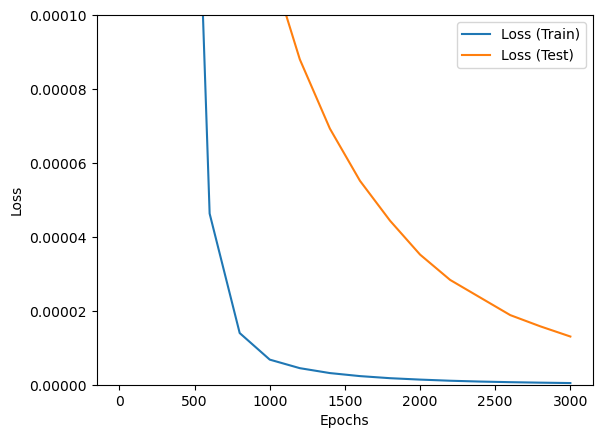

In [15]:
import matplotlib.pyplot as plt

# Create the figure and axes objects
fig, ax1 = plt.subplots()

# Create the x data (time in epochs))
x_data = [EPOCH_SAVE_FREQ*i for i in range(EPOCHS//EPOCH_SAVE_FREQ + 1)]

# Plot the data on the first y-axis
loss_plot1, = ax1.plot(x_data, train_loss_data)
loss_plot2, = ax1.plot(x_data, test_loss_data)

# Axis limits
ax1.set_ylim([0, 0.0001])

# Set the labels for the x-axis and y-axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Set the ticks for the x-axis
#ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(1))

# Add a legend
plt.legend([loss_plot1, loss_plot2],
           ["Loss (Train)", "Loss (Test)"],
           loc='upper right'
)

# Show the plots
plt.show()